imports

In [216]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import scipy.stats as scs
import os


plt.style.use('fivethirtyeight')

In [96]:
plt.style.available

['seaborn-dark',
 'seaborn-darkgrid',
 'seaborn-ticks',
 'fivethirtyeight',
 'seaborn-whitegrid',
 'classic',
 '_classic_test',
 'fast',
 'seaborn-talk',
 'seaborn-dark-palette',
 'seaborn-bright',
 'seaborn-pastel',
 'grayscale',
 'seaborn-notebook',
 'ggplot',
 'seaborn-colorblind',
 'seaborn-muted',
 'seaborn',
 'Solarize_Light2',
 'seaborn-paper',
 'bmh',
 'tableau-colorblind10',
 'seaborn-white',
 'dark_background',
 'seaborn-poster',
 'seaborn-deep']

In [83]:
def get_csv(chamber, congress):
    fpath = '../congress-data/%s/%s_%d.csv' % (chamber, chamber, congress)
    cong_df = pd.read_csv(fpath, index_col=0)
    
    cong_df['PCT'] = cong_df['missed_votes'] / cong_df['total_votes']
    cong_df = convert_abbrev_to_name(cong_df, 'state')
    
    if chamber == 'house':
        inds = cong_df['at_large'] == True
        cong_df.loc[inds, 'district'] = '0'
    
    return cong_df

def convert_abbrev_to_name(df, state_col):
    '''
        Converts the state abbreviations to their full name
        
        Takes a dataframe and the column name of the states
        
        Returns a dataframe with the updated information in a new column, called state_names
    '''
    states = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 
              'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'DC': 'District Of Columbia', 
              'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 
              'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 
              'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 
              'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 
              'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 
              'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 
              'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 
              'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 
              'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'}

    series = df[state_col].values

    series = np.array([states[key] for key in series])
    df['state_names'] = series

    return df

## Data Exploration
Why do Representatives miss votes?

### Quantitative Variables:
    - age
    - seniority
    - distance from D.C.
### Qualitative Variables:
    - gender
    - party
    - region of country
    



## The House of Representatives

### Age vs Missed Votes%
#### Current Congress

In [92]:
def create_datetime_obj(obj):
    datetime_obj = datetime.datetime.strptime(obj, '%Y-%m-%d')
    
    return datetime_obj

def get_age_votes_correlation(chamber, congress, plot=True):
    chamber_data = get_csv(chamber, congress)
    chamber_data = chamber_data.reset_index()
    chamber_data['dob'] = chamber_data['dob'].apply(create_datetime_obj)
    
    for i in range(len(chamber_data)):
        birthdate = chamber_data.loc[i]['dob'].date()
        today = datetime.date.today()
        difference = today - birthdate
        age = (difference.days + difference.seconds/86400)/365.2425

        chamber_data.loc[i, 'age'] = age
        
    ages = chamber_data['age']
    pcts = chamber_data['PCT']
    
    if plot:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.scatter(ages, pcts)
        
        ax.set_xlabel('Age')
        ax.set_ylabel('Percentage of Missed Votes')
        ax.set_title('Age vs. Missed Vote %% for the %d %s' % (congress, chamber))
        
    return scs.pearsonr(ages, pcts)
    

(0.10799372336694703, 0.02670920575101012)

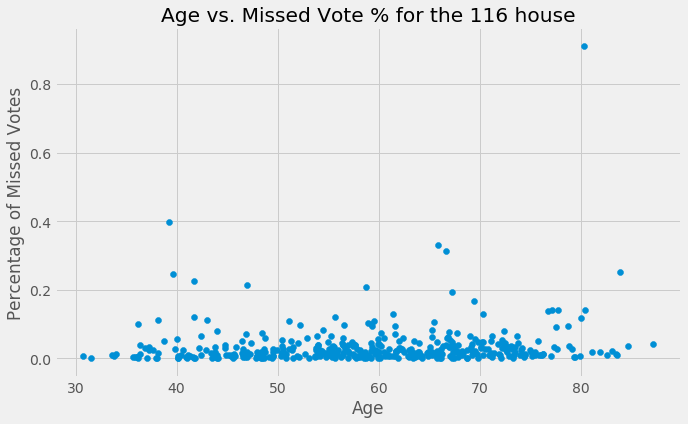

In [98]:
get_age_votes_correlation('house', 116)

(-0.016053956398708002, 0.8766277850883092)

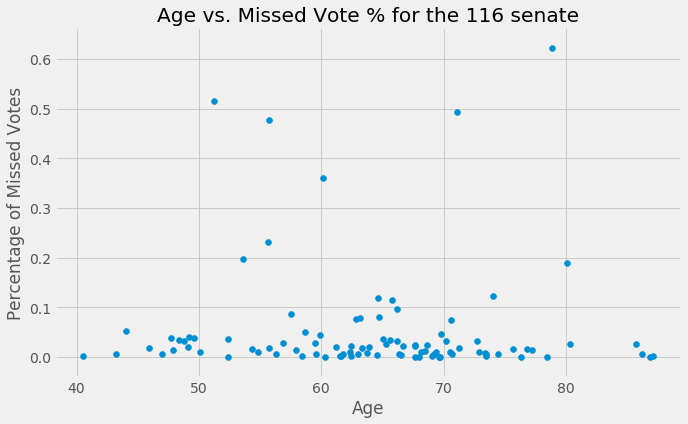

In [99]:
get_age_votes_correlation('senate', 116)

### Missed votes by session for house and senate

In [142]:
def plot_missed_votes_by_session(chamber):

    fig, ax = plt.subplots(figsize=(18, 10))

    if chamber=='senate':
        lower=101
    else:
        lower=102
    
    for session in range(lower, 117):
        data = get_csv(chamber, session)
        pcts = data['PCT']
        sessions = np.full((len(pcts),), session)
        avg = np.mean(pcts)
        ax.scatter(sessions, pcts, alpha=0.5, c='#90CAF9')
        ax.scatter(session, avg, alpha=1, c='#EF9A9A', edgecolor='black', s=100)
        
    ax.set_xlabel('Congressional Sessions')
    ax.set_ylabel('Percentage of Missed Votes')
    ax.set_title('%% of missed votes by session for the %s' % chamber)
    ax.set_ylim(-0.05, 1.05)

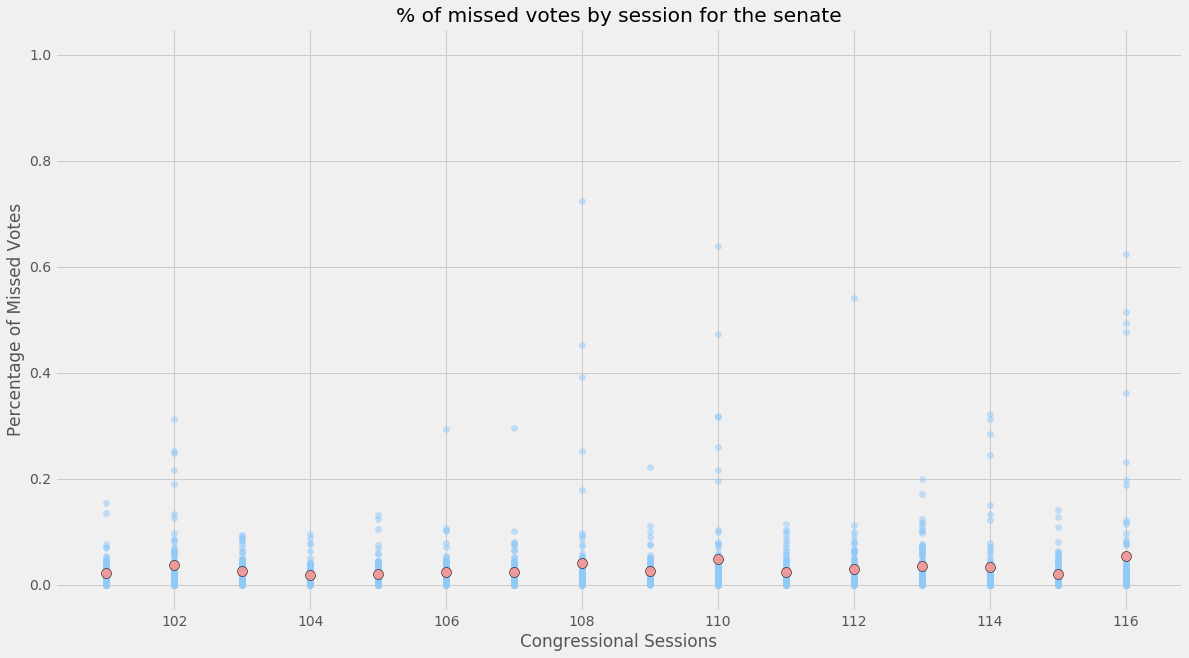

In [143]:
plot_missed_votes_by_session('senate')

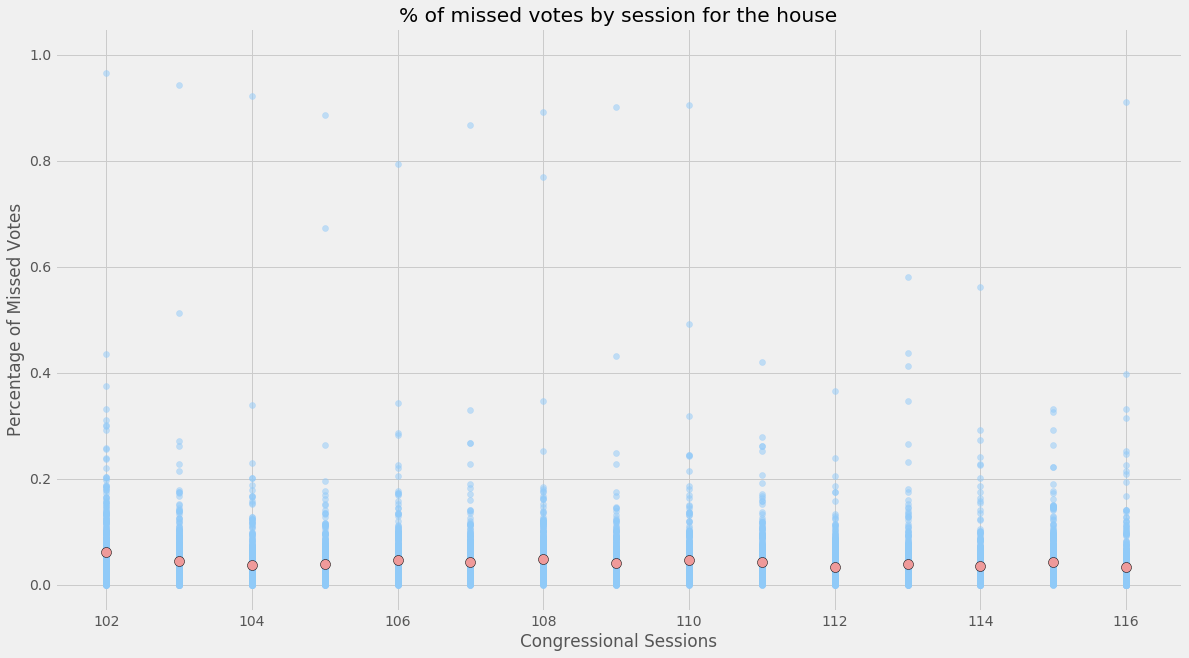

In [144]:
plot_missed_votes_by_session('house')

In [168]:
def plot_avgs_by_session():
    fig, ax = plt.subplots(figsize=(9, 6))

    for session in range(101, 117):
        if session != 101:
            house_data = get_csv('house', session)
            house_avg = np.mean(house_data['missed_votes']) / np.mean(house_data['total_votes'])
            house_label = 'House of Representatives' if session==102 else ''
            ax.scatter(session, house_avg, alpha=0.5, c='#AED581', edgecolor='black', s=50, label=house_label)
            
        senate_data = get_csv('senate', session)
        senate_avg = np.mean(senate_data['missed_votes']) / np.mean(senate_data['total_votes'])
        senate_label = 'Senate' if session==102 else ''
        ax.scatter(session, senate_avg, alpha=0.5, c='#FFF176', edgecolor='black', s=50, label=senate_label)
        
    ax.set_xlabel('Congressional Sessions')
    ax.set_ylabel('Average % of Missed Votes')
    ax.set_title('Average % of missed votes by session for both chambers')
    ax.set_ylim(-0.05, 1.05)
    ax.legend()

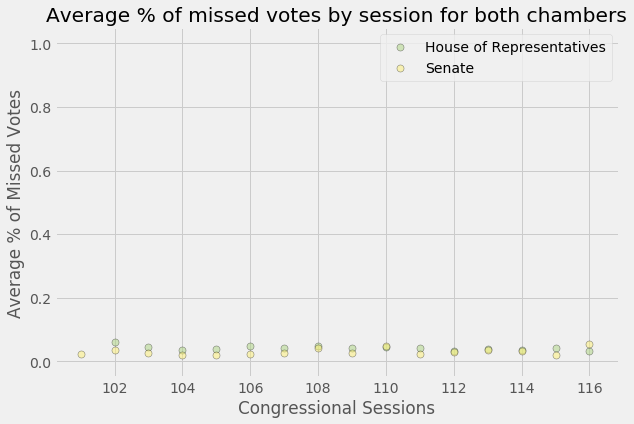

In [169]:
plot_avgs_by_session()

### Seniority vs Missed Votes

In [198]:
def plotting_seniority_against_missed_votes(chamber, congress, plot=True):
    chamber_data = get_csv(chamber, congress)
    chamber_data = chamber_data.reset_index()
        
    seniority = chamber_data['seniority']
    
    num_missed = chamber_data['missed_votes']
    
    if plot:
        fig, ax = plt.subplots(figsize=(10, 6))
        ax.scatter(seniority, num_missed, c='#90CAF9', alpha=0.5)
        
        idx = chamber_data.groupby('seniority')['missed_votes'].mean().index
        means = chamber_data.groupby('seniority')['missed_votes'].mean().values
        
        ax.scatter(idx, means, alpha=1, c='#EF9A9A', edgecolor='black', s=50)
        
        ax.set_xlabel('Seniority')
        ax.set_ylabel('Number of Missed Votes')
        ax.set_title('Seniority vs. Missed Votes for the %d %s' % (congress, chamber))
        
    return scs.pearsonr(seniority, num_missed)

(0.15674642213808523, 0.0013767864058141185)

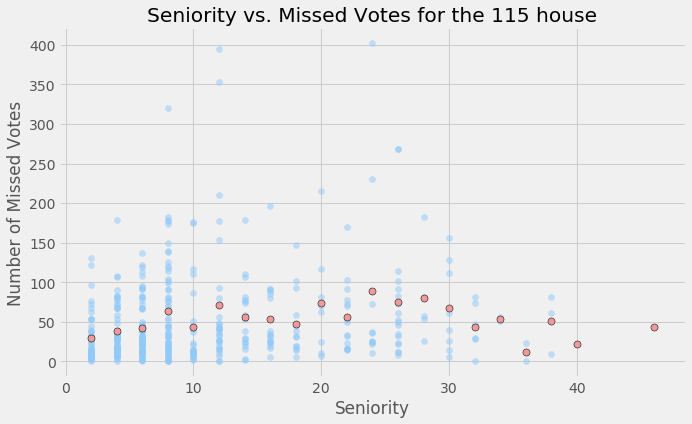

In [199]:
plotting_seniority_against_missed_votes('house', 115)

(-0.04343996451588167, 0.6743057472071874)

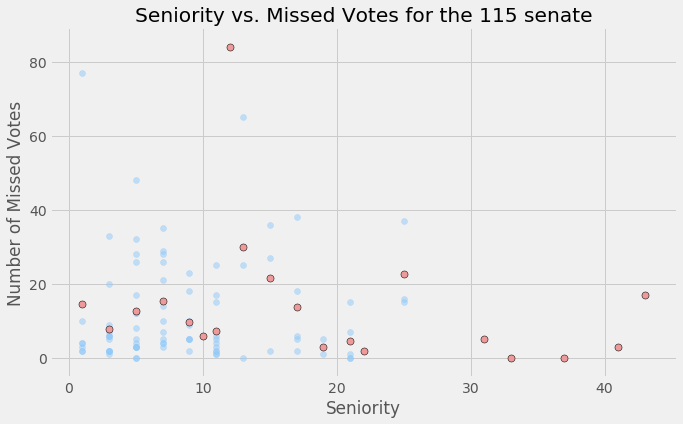

In [202]:
plotting_seniority_against_missed_votes('senate', 115)

In [203]:
def plotting_seniority_against_missed_votes_for_all_sessions(chamber):
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    for session in range(102, 117):
        chamber_data = get_csv(chamber, session)
        chamber_data = chamber_data.reset_index()

        idx = chamber_data.groupby('seniority')['missed_votes'].mean().index
        means = chamber_data.groupby('seniority')['missed_votes'].mean().values

        ax.scatter(idx, means, alpha=1, c='#EF9A9A', edgecolor='black', s=50)

        ax.set_xlabel('Seniority')
        ax.set_ylabel('Number of Missed Votes')
        ax.set_title('Seniority vs. Missed Votes for the %s' % (chamber))



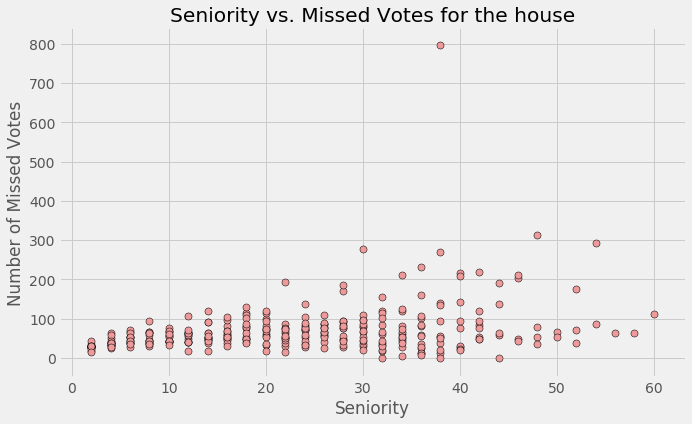

In [204]:
plotting_seniority_against_missed_votes_for_all_sessions('house')

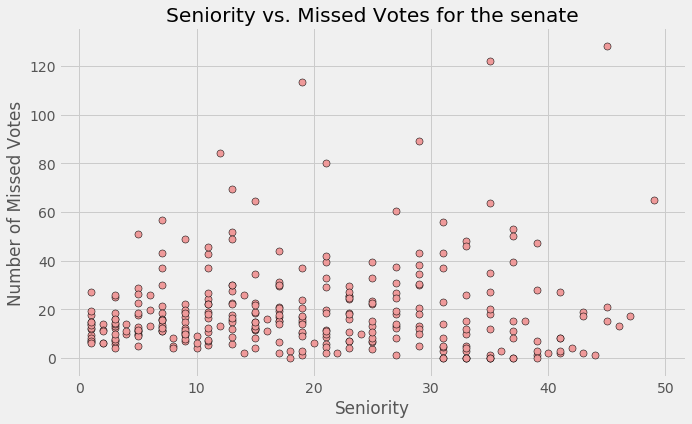

In [205]:
plotting_seniority_against_missed_votes_for_all_sessions('senate')

### Plotting Members of Congress Missed Votes Adjusted For Seniority

ParserError: Error tokenizing data. C error: Expected 1 fields in line 8, saw 469


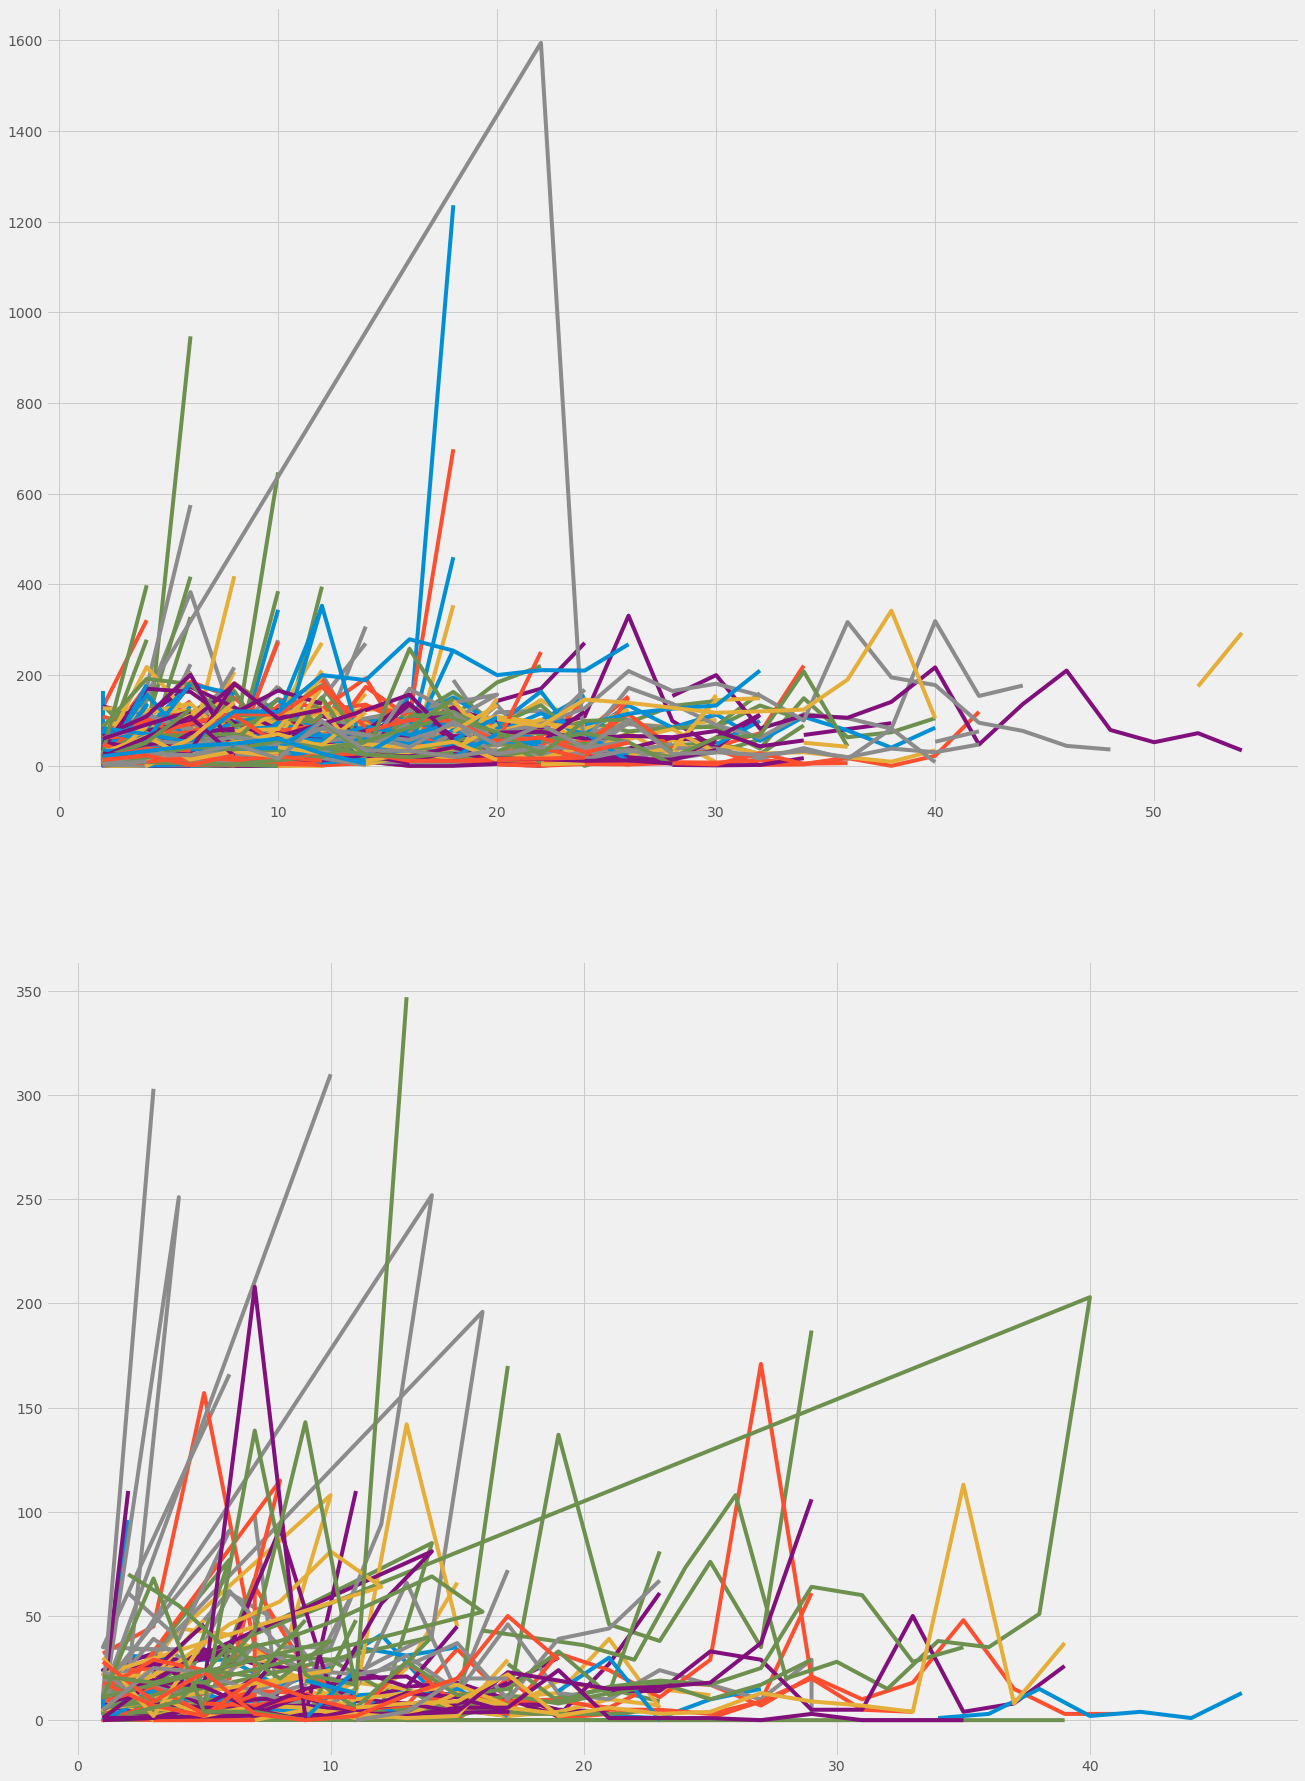

In [224]:
fpath = '../congress-data/members/'

fig, ax = plt.subplots(2, 1, figsize=(20, 30))

member_files = os.listdir(fpath)
for file in member_files:
    path = fpath + file
    df = pd.read_csv(path, index_col=0)
    df = df.sort_values('congress')
    
    seniority = df['seniority']
    num_missed = df['missed_votes']
    
    if df.loc[0]['chamber'] == 'House':
        ax[0].plot(seniority, num_missed)
        
    elif df.loc[0]['chamber'] == 'Senate':
        ax[1].plot(seniority, num_missed)
    

In [222]:
df = df.sort_values('congress')
df['seniority']

16     2
15     4
14     6
13     8
12    10
11    12
10    14
9     16
8     18
7     20
6     22
5     24
4     26
3     28
2     30
1     32
0     34
Name: seniority, dtype: int64

In [211]:
df.columns

Index(['id', 'first_name', 'last_name', 'dob', 'gender', 'current_party',
       'govtrack_id', 'cspan_id', 'congress', 'chamber', 'state', 'district',
       'senate_class', 'party', 'leadership_role', 'seniority', 'total_votes',
       'missed_votes', 'total_present', 'bills_sponsored', 'bills_cosponsored',
       'votes_with_party_pct', 'votes_against_party_pctcommittees',
       'subcommittees', 'committees', 'votes_against_party_pct'],
      dtype='object')